<a href="https://colab.research.google.com/github/Ayush-b500/Comparative-Analysis-of-Bias-Mitigation-Techniques-for-Fair-Gender-Aware-Income-Prediction/blob/main/Comparative%20Analysis%20of%20Bias-Mitigation%20Techniques%20for%20Fair%20Gender-Aware%20Income%20Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.8/93.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 18.6 MB/s eta 0:00:00
Columns in dataset: ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'class']
   age  workclass  fnlwgt     education  education-num      marital-status  \
0   25    Private  226802          11th              7       Never-married   
1   38    Private   89814       HS-grad              9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm             12  Married-civ-spouse   
3   44    Private  160323  Some-college             10  Married-civ-spouse   
4   18        NaN  103497  Some-college             10       Never-married   

          occupation relationship 

,selection_rate
group,
Female,0.076385
Male,0.248469



Equalized Odds (per group):
  Equalized Odds Difference: 0.090 (max ΔTPR or ΔFPR)


,selection_rate,tpr,fpr,accuracy
group,,,,
Female,0.076385,0.518987,0.019517,0.927939
Male,0.248469,0.609211,0.092796,0.817374



================= Mitigated (Reweighting) =================
Performance:
  Accuracy : 0.811
  Precision: 0.576
  Recall   : 0.805
  F1-score : 0.671

Demographic Parity:
  Demographic Parity Difference: 0.170 (closer to 0 is fairer)
  Selection rate by group:


,selection_rate
group,
Female,0.221330
Male,0.390976



Equalized Odds (per group):
  Equalized Odds Difference: 0.076 (max ΔTPR or ΔFPR)


,selection_rate,tpr,fpr,accuracy
group,,,,
Female,0.221330,0.851718,0.140335,0.858761
Male,0.390976,0.796478,0.215987,0.787771



================= Mitigated (Balanced Resampling) =================
Performance:
  Accuracy : 0.805
  Precision: 0.564
  Recall   : 0.809
  F1-score : 0.665

Demographic Parity:
  Demographic Parity Difference: 0.175 (closer to 0 is fairer)
  Selection rate by group:


,selection_rate
group,
Female,0.226065
Male,0.401388



Equalized Odds (per group):
  Equalized Odds Difference: 0.081 (max ΔTPR or ΔFPR)


,selection_rate,tpr,fpr,accuracy
group,,,,
Female,0.226065,0.840868,0.147072,0.851554
Male,0.401388,0.803251,0.227970,0.781441



================= Summary of all models =================


,model,accuracy,precision,recall,f1,dp_diff,eo_diff
0,Baseline (Logistic Regression),0.854023,0.743672,0.594980,0.661068,0.172084,0.090224
1,Mitigated (Reweighting),0.811301,0.575535,0.805191,0.671264,0.169646,0.075653
2,Mitigated (Balanced Resampling),0.804682,0.564016,0.809184,0.664714,0.175323,0.080898


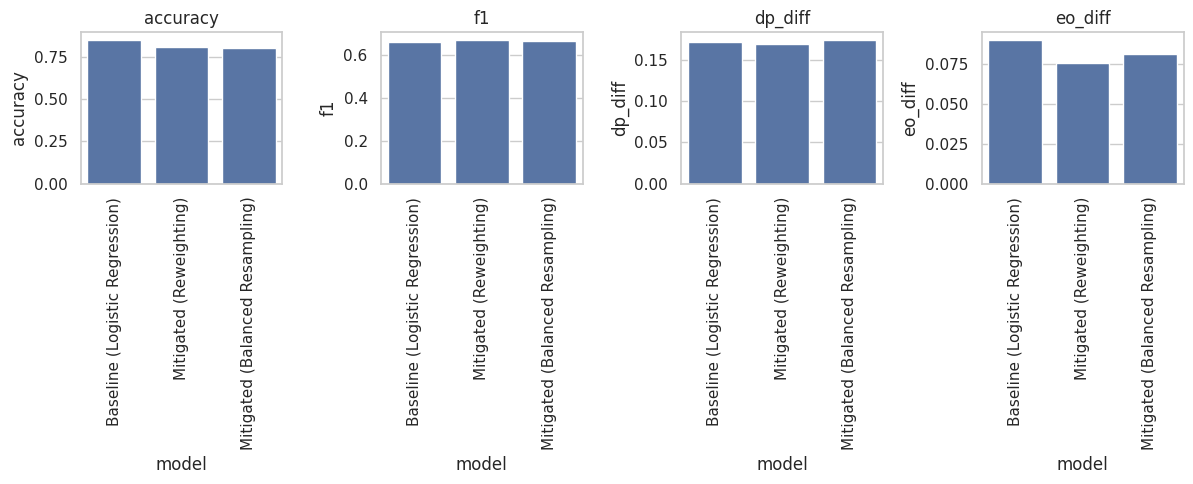


Done! You can now use these numbers and plots in your research paper to discuss:
- How reweighting and balanced resampling change fairness metrics
- The trade-off between accuracy/F1 and fairness (dp_diff, eo_diff)


In [1]:
# =========================================================
# Bias-Mitigation Comparison on Adult Dataset
# No Fairlearn reductions, fully NumPy 2.0 compatible
# =========================================================

# 1. Install required libraries
!pip install -q scikit-learn pandas seaborn matplotlib openml

# 2. Imports
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

sns.set(style="whitegrid")

# 3. Load and preprocess Adult Income dataset
print("Downloading Adult dataset from OpenML...")
adult = fetch_openml("adult", version=2, as_frame=True)
df = adult.frame.copy()

print("Columns in dataset:", df.columns.tolist())
print(df.head())

# Target: income >50K as 1, <=50K as 0
df["income"] = (df["class"] == ">50K").astype(int)
df.drop(columns=["class"], inplace=True)

# Sensitive feature: 'sex' (Male/Female)
sensitive_feature_name = "sex"
df[sensitive_feature_name] = df[sensitive_feature_name].astype(str)

# Separate features and target
X = df.drop(columns=["income"])
y = df["income"]

# One-hot encode categorical features
X = pd.get_dummies(X, drop_first=True)

# Train-test split (also split sensitive attribute)
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
    X, y, df[sensitive_feature_name],
    test_size=0.3,
    random_state=42,
    stratify=y
)

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train shape:", X_train_scaled.shape)
print("Test shape :", X_test_scaled.shape)

# 4. Fairness metric helpers (implemented manually)

def group_rates(y_true, y_pred, group):
    """
    Compute selection rate, TPR and FPR per sensitive group.
    Returns DataFrame indexed by group with columns:
    ['selection_rate', 'tpr', 'fpr', 'accuracy']
    """
    data = pd.DataFrame({
        "y_true": y_true,
        "y_pred": y_pred,
        "group": group
        })
    rows = []
    for g, sub in data.groupby("group"):
        sr = sub["y_pred"].mean()  # P(pred=1 | group=g)
        # TPR and FPR
        positives = sub[sub["y_true"] == 1]
        negatives = sub[sub["y_true"] == 0]
        tpr = positives["y_pred"].mean() if len(positives) > 0 else np.nan
        fpr = negatives["y_pred"].mean() if len(negatives) > 0 else np.nan
        acc = (sub["y_true"] == sub["y_pred"]).mean()
        rows.append({
            "group": g,
            "selection_rate": sr,
            "tpr": tpr,
            "fpr": fpr,
            "accuracy": acc
        })
    return pd.DataFrame(rows).set_index("group")

def demographic_parity_diff(y_pred, group):
    """Difference between max and min selection rate across groups."""
    df = pd.DataFrame({"y_pred": y_pred, "group": group})
    rates = df.groupby("group")["y_pred"].mean()
    return rates.max() - rates.min(), rates

def equalized_odds_diff(y_true, y_pred, group):
    """
    Equalized odds difference: the max difference in TPR or FPR
    between any two groups. For 2 groups: max(|ΔTPR|, |ΔFPR|).
    """
    stats = group_rates(y_true, y_pred, group)
    tpr = stats["tpr"]
    fpr = stats["fpr"]
    tpr_diff = tpr.max() - tpr.min()
    fpr_diff = fpr.max() - fpr.min()
    return max(tpr_diff, fpr_diff), stats

# 5. Evaluation function

def evaluate_model(y_true, y_pred, sensitive_features, model_name="model"):
    # Performance
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Fairness
    dp_diff, dp_rates = demographic_parity_diff(y_pred, sensitive_features)
    eo_diff, eo_stats = equalized_odds_diff(y_true, y_pred, sensitive_features)

    print(f"\n================= {model_name} =================")
    print("Performance:")
    print(f"  Accuracy : {acc:.3f}")
    print(f"  Precision: {prec:.3f}")
    print(f"  Recall   : {rec:.3f}")
    print(f"  F1-score : {f1:.3f}")

    print("\nDemographic Parity:")
    print(f"  Demographic Parity Difference: {dp_diff:.3f} (closer to 0 is fairer)")
    print("  Selection rate by group:")
    display(dp_rates.to_frame(name="selection_rate"))

    print("\nEqualized Odds (per group):")
    print(f"  Equalized Odds Difference: {eo_diff:.3f} (max ΔTPR or ΔFPR)")
    display(eo_stats)

    return {
        "model": model_name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "dp_diff": dp_diff,
        "eo_diff": eo_diff
    }

# 6. Baseline model (no bias mitigation)

baseline_clf = LogisticRegression(solver="liblinear", max_iter=1000)
baseline_clf.fit(X_train_scaled, y_train)

y_pred_baseline = baseline_clf.predict(X_test_scaled)

results = []
results.append(
    evaluate_model(y_test, y_pred_baseline, A_test, model_name="Baseline (Logistic Regression)")
)

# 7. Mitigation 1: Reweighting based on (group, label) frequencies

# Build DataFrame for training set
df_train = pd.DataFrame({
    "y": y_train.values,
    "group": A_train.values
})
# Count how frequent each (group, y) combination is
combo_counts = df_train.groupby(["group", "y"]).size()
combo_freq = combo_counts / len(df_train)
combo_freq = combo_freq.rename("freq").reset_index()

# Merge frequencies back to each training example
df_train_with_freq = df_train.merge(combo_freq, on=["group", "y"], how="left")

# Define sample weights as inverse of frequency
sample_weights = 1.0 / df_train_with_freq["freq"].values

reweighted_clf = LogisticRegression(solver="liblinear", max_iter=1000)
reweighted_clf.fit(X_train_scaled, y_train, sample_weight=sample_weights)

y_pred_reweighted = reweighted_clf.predict(X_test_scaled)

results.append(
    evaluate_model(y_test, y_pred_reweighted, A_test, model_name="Mitigated (Reweighting)")
)

# 8. Mitigation 2: Balanced Resampling by (group, label)

# Create index-based DataFrame to resample
df_train_idx = df_train.copy()
df_train_idx["idx"] = np.arange(len(df_train_idx))

groups = df_train_idx.groupby(["group", "y"])
min_size = groups.size().min()   # smallest group size

balanced_parts = []
for (g, yv), sub in groups:
    balanced_parts.append(sub.sample(n=min_size, random_state=42))

balanced_df = pd.concat(balanced_parts, ignore_index=True)
balanced_idx = balanced_df["idx"].values

X_train_bal = X_train_scaled[balanced_idx]
y_train_bal = y_train.values[balanced_idx]
A_train_bal = A_train.values[balanced_idx]

balanced_clf = LogisticRegression(solver="liblinear", max_iter=1000)
balanced_clf.fit(X_train_bal, y_train_bal)

y_pred_balanced = balanced_clf.predict(X_test_scaled)

results.append(
    evaluate_model(y_test, y_pred_balanced, A_test, model_name="Mitigated (Balanced Resampling)")
)

# 9. Summary table

results_df = pd.DataFrame(results)
print("\n================= Summary of all models =================")
display(results_df)

# 10. Plot performance vs fairness

plt.figure(figsize=(12, 5))
metrics_to_plot = ["accuracy", "f1", "dp_diff", "eo_diff"]

for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(1, 4, i)
    sns.barplot(x="model", y=metric, data=results_df)
    plt.xticks(rotation=90)
    plt.title(metric)

plt.tight_layout()
plt.show()

print("\nDone! You can now use these numbers and plots in your research paper to discuss:")
print("- How reweighting and balanced resampling change fairness metrics")
print("- The trade-off between accuracy/F1 and fairness (dp_diff, eo_diff)")
